<div class="alert alert-block alert-warning"><b>PLEASE READ BEFORE:</b><br>
    1. This notebook is after explore_zillow.ipynb and mainly focused on clustering the scaled train dataset on four groups of features.<br>
    2. If you are looking for modeling, please find model.zillow.ipynb in the same repo.<br>
    3. If you are looking for exploration, please find explore_zillow.ipynb in the same repo.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import acquire, prepare, wrangle_zillow, features, model

In [2]:
zillow = acquire.get_zillow_clustering()
zillow.shape

(77579, 69)

In [3]:
# Wrangle the zillow dataset

train, validate, test = wrangle_zillow.wrangle_zillow_clustering_2(zillow)

# Double check the shape of the splitted datasets
train.shape, validate.shape, test.shape

((31028, 20), (13299, 20), (7823, 20))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31028 entries, 71142 to 59426
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      31028 non-null  int64  
 1   bathroomcnt                   31028 non-null  float64
 2   bedroomcnt                    31028 non-null  float64
 3   buildingqualitytypeid         31028 non-null  float64
 4   calculatedfinishedsquarefeet  31028 non-null  float64
 5   finishedsquarefeet12          31028 non-null  float64
 6   fullbathcnt                   31028 non-null  float64
 7   latitude                      31028 non-null  float64
 8   longitude                     31028 non-null  float64
 9   lotsizesquarefeet             31028 non-null  float64
 10  roomcnt                       31028 non-null  float64
 11  yearbuilt                     31028 non-null  float64
 12  structuretaxvaluedollarcnt    31028 non-null  float64
 1

In [5]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,6.0,1951.0,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,0.0,1998.0,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,9.0,1971.0,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,0.0,1954.0,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,8.0,1956.0,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0


## Clustering
- Group 1: logtaxvaluedollarcnt, logerror
- Group 2: taxvaluedollarcnt, logerror
- Group 2: (taxvaluedollarcnt, logerror), (latitude, longitute)
- Group 3: (taxvaluedollarcnt, logerror), (year)

In [6]:
# Log-transform taxvaluedollarcnt
train['logtaxvaluedollarcnt'] = np.log10(train.taxvaluedollarcnt)
validate['logtaxvaluedollarcnt'] = np.log10(validate.taxvaluedollarcnt)
test['logtaxvaluedollarcnt'] = np.log10(test.taxvaluedollarcnt)

In [7]:
train.shape

(31028, 21)

In [8]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,1951.0,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,1998.0,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,1971.0,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,1954.0,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,1956.0,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425


### Clustering Group 1: logtaxvaluedollarcnt, logerror

In [9]:
# Choose Group 1 to cluster on

cols_to_cluster = ['logtaxvaluedollarcnt', 'logerror']
train_g1 = train[cols_to_cluster]
validate_g1 = validate[cols_to_cluster]
test_g1 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g1_scaled, validate_g1_scaled, test_g1_scaled = prepare.standard_scaler(train_g1, 
                                                                                      validate_g1, 
                                                                                      test_g1)
scaler, train_g1_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 2))

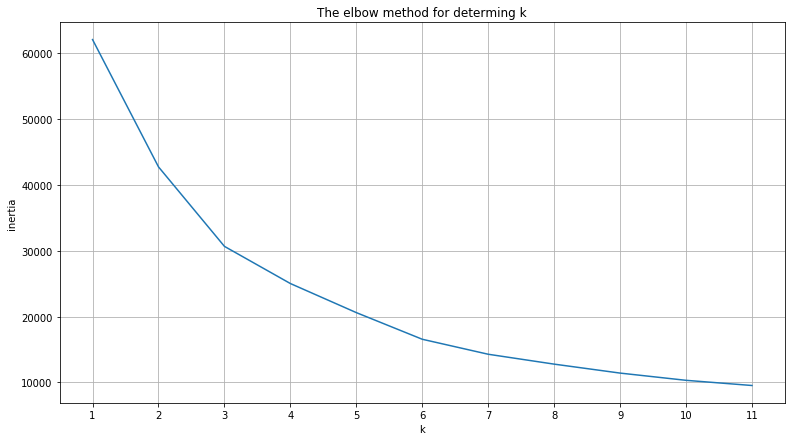

In [10]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g1_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [11]:
kmeans1, cluster1 = model.kmeans_labels(train_g1_scaled, cols_to_cluster, 6)
cluster1.head()

,cluster
71142,1
11459,1
54330,1
46830,0
53521,0


In [12]:
# Predict the clustering for validate

kmeans1.inertia_

16561.587830369084

In [13]:
train = pd.concat([train, cluster1], axis=1)
train.rename(columns={'cluster': 'cluster1'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,1
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,1
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,1
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0


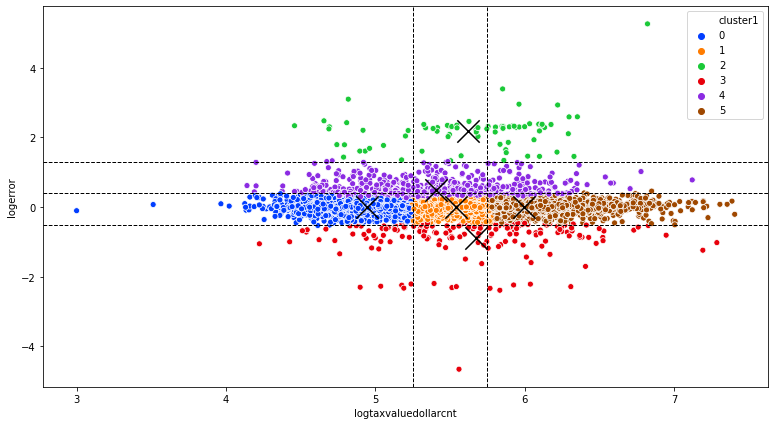

In [14]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster1', palette='bright')
plt.axhline(0.4, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(5.25, color='k', linestyle='dashed', linewidth=1)
plt.axvline(5.75, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster1').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')

In [15]:
train.cluster1.value_counts()

1    15165
5     8233
0     6522
4      860
3      172
2       76
Name: cluster1, dtype: int64

### Clustering Group 2: taxvaluedollarcnt, logerror

In [16]:
# Choose Group 2 to cluster on

cols_to_cluster = ['taxvaluedollarcnt', 'logerror']
train_g2 = train[cols_to_cluster]
validate_g2 = validate[cols_to_cluster]
test_g2 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g2_scaled, validate_g2_scaled, test_g2_scaled = prepare.standard_scaler(train_g2, 
                                                                                      validate_g2, 
                                                                                      test_g2)
scaler, train_g2_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 2))

In [17]:
train_g2_scaled.head()

,taxvaluedollarcnt,logerror
71142,-0.125105,0.151133
11459,-0.175683,-0.096466
54330,-0.201437,-0.172529
46830,-0.600713,-0.270126
53521,-0.624506,-0.316977


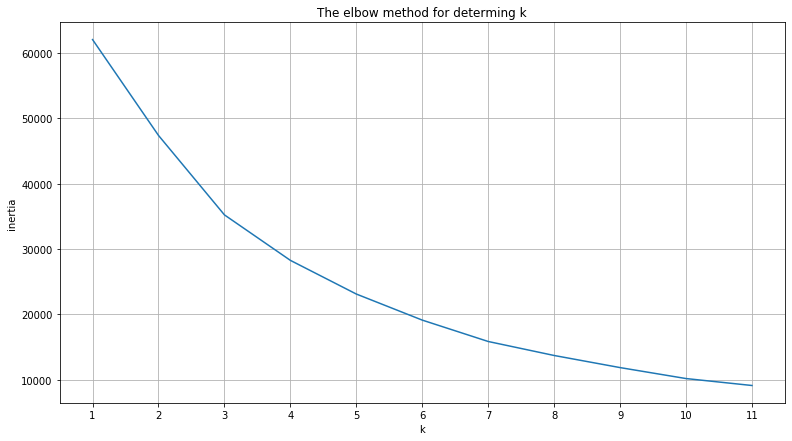

In [18]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g2_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [19]:
kmeans2, cluster2 = model.kmeans_labels(train_g2_scaled, cols_to_cluster, 6)
cluster2.head()

,cluster
71142,0
11459,0
54330,0
46830,0
53521,0


In [20]:
# Take a look at the see of kmeans2

kmeans2.inertia_

19105.22210476697

In [21]:
train = pd.concat([train, cluster2], axis=1)
train.rename(columns={'cluster': 'cluster2'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,1,0
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,1,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,1,0
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0,0


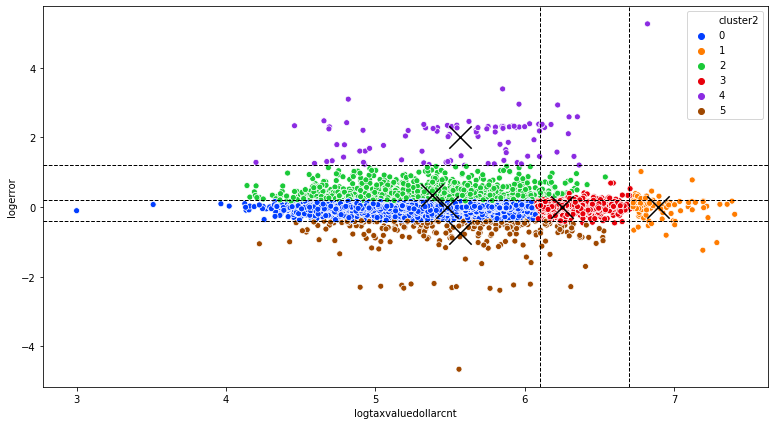

In [22]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')

In [23]:
train.cluster2.value_counts()

0    26841
3     2195
2     1555
5      231
1      113
4       93
Name: cluster2, dtype: int64

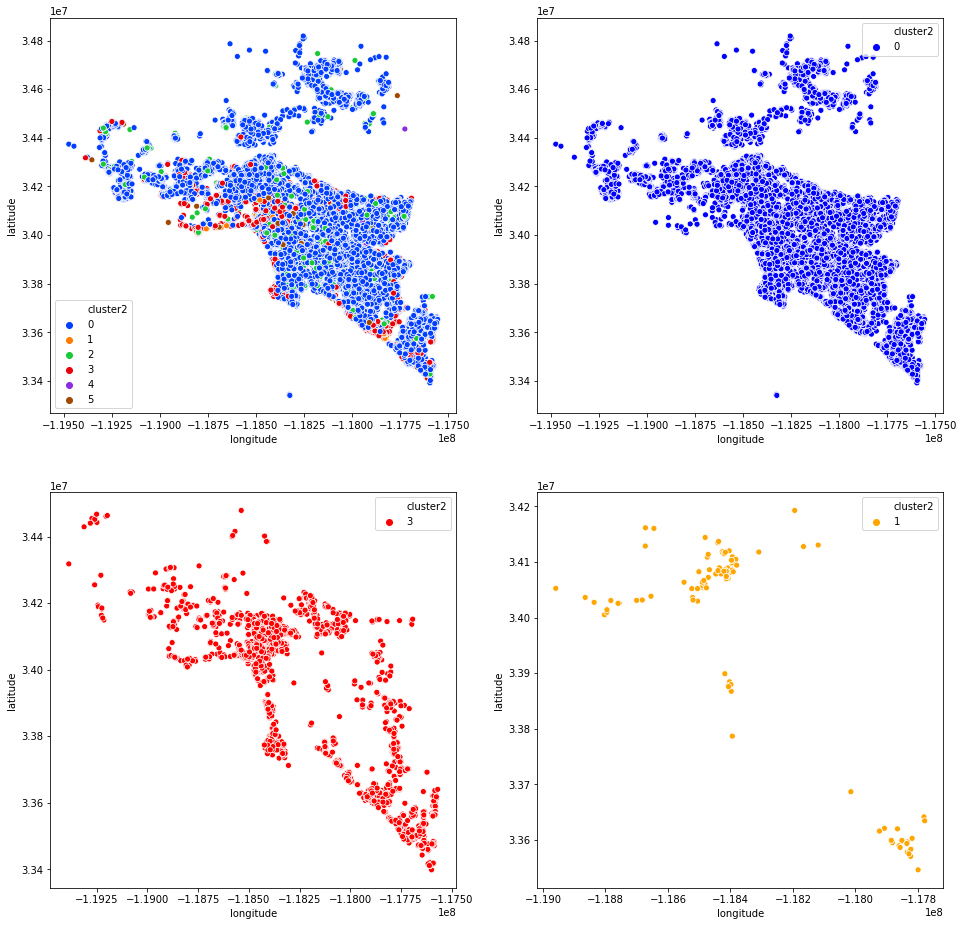

In [24]:
plt.figure(figsize=(16,16))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 0], 
                           x='longitude', y='latitude', hue='cluster2', palette=['blue'])

plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 3], 
                           x='longitude', y='latitude', hue='cluster2', palette=['red'])

plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 1], 
                           x='longitude', y='latitude', hue='cluster2', palette=['orange'])

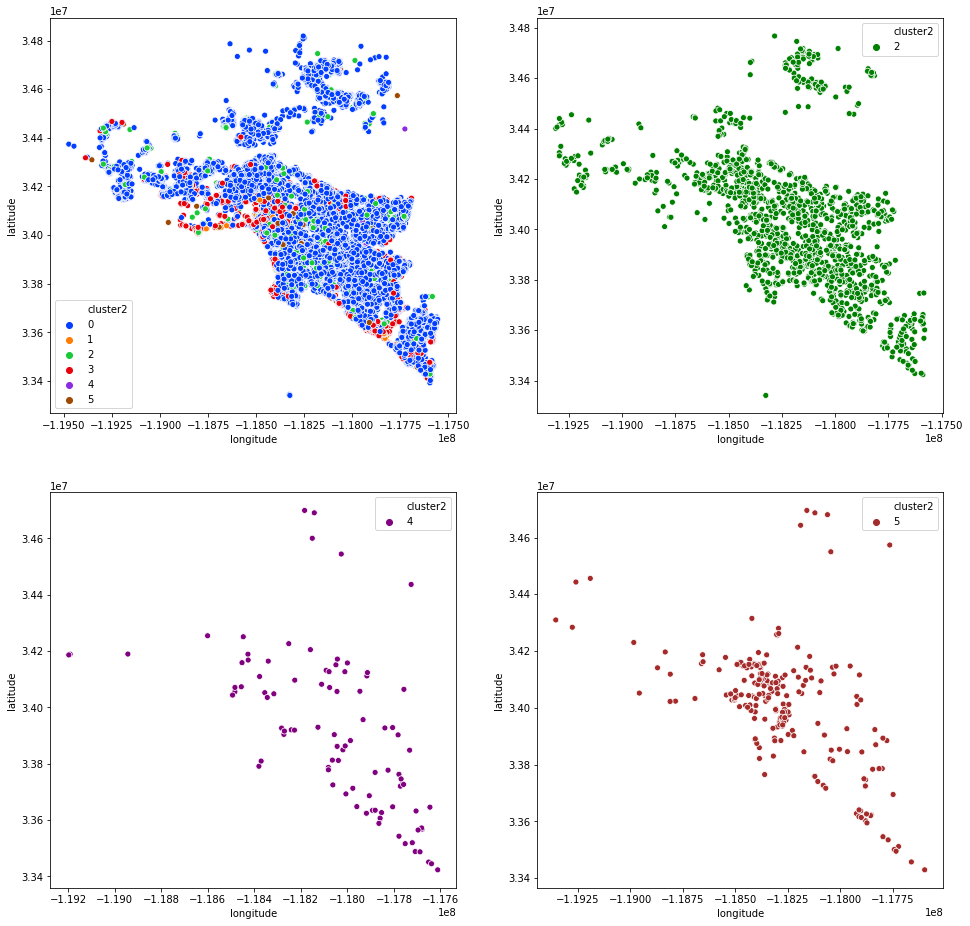

In [25]:
plt.figure(figsize=(16,16))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 2], 
                           x='longitude', y='latitude', hue='cluster2', palette=['green'])

plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 4], 
                           x='longitude', y='latitude', hue='cluster2', palette=['purple'])

plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 5], 
                           x='longitude', y='latitude', hue='cluster2', palette=['brown'])

### Clustering Group 3: (logtaxvaluedollarcnt, logerror), (latitude, longitude)

In [26]:
# Choose Group 3 to cluster on

cols_to_cluster = ['logtaxvaluedollarcnt', 'logerror', 'latitude', 'longitude']
train_g3 = train[cols_to_cluster]
validate_g3 = validate[cols_to_cluster]
test_g3 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g3_scaled, validate_g3_scaled, test_g3_scaled = prepare.standard_scaler(train_g3, 
                                                                                      validate_g3, 
                                                                                      test_g3)
scaler, train_g3_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 4))

In [27]:
train_g3_scaled.head()

,logtaxvaluedollarcnt,logerror,latitude,longitude
71142,0.263456,0.151133,1.557178,-3.031341
11459,0.167803,-0.096466,1.508714,-0.530860
54330,0.115565,-0.172529,-1.093355,0.735242
46830,-1.506076,-0.270126,0.266709,0.768530
53521,-1.763605,-0.316977,-0.716131,0.667128


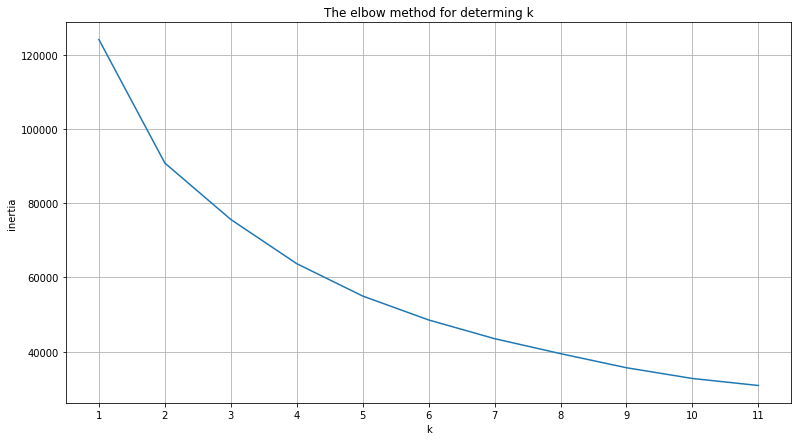

In [28]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g3_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [29]:
kmeans3, cluster3 = model.kmeans_labels(train_g3_scaled, cols_to_cluster, 6)
cluster3.head()

,cluster
71142,0
11459,0
54330,4
46830,1
53521,1


In [30]:
kmeans3.inertia_

48544.99754562709

In [31]:
train = pd.concat([train, cluster3], axis=1)
train.rename(columns={'cluster': 'cluster3'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2,cluster3
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,270458.0,5302.10,0.045179,1,0,1,5.640375,1,0,0
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,91238.0,6231.12,0.000996,1,0,0,5.601164,1,0,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,215204.0,4447.62,-0.012577,0,1,0,5.579750,1,0,4
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,30210.0,1311.36,-0.029993,0,0,0,4.914993,0,0,1
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,21725.0,1066.06,-0.038353,0,1,0,4.809425,0,0,1


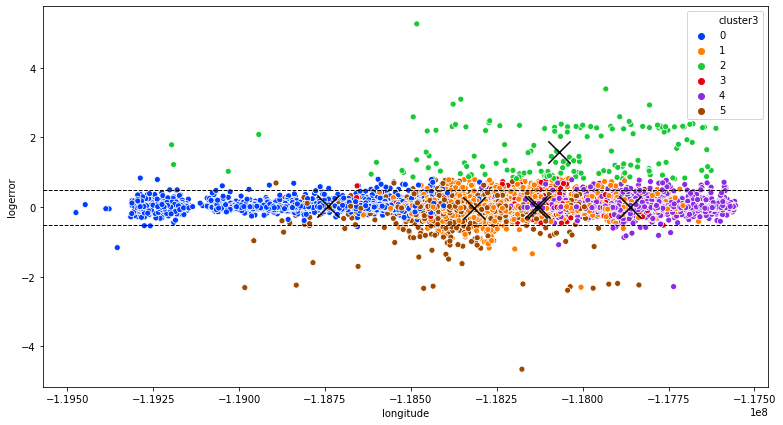

In [32]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='longitude', y='logerror', hue='cluster3', palette='bright')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster3').mean().plot.scatter(y='logerror', x='longitude', 
                                             marker='x', s=500, ax=ax, c='black')

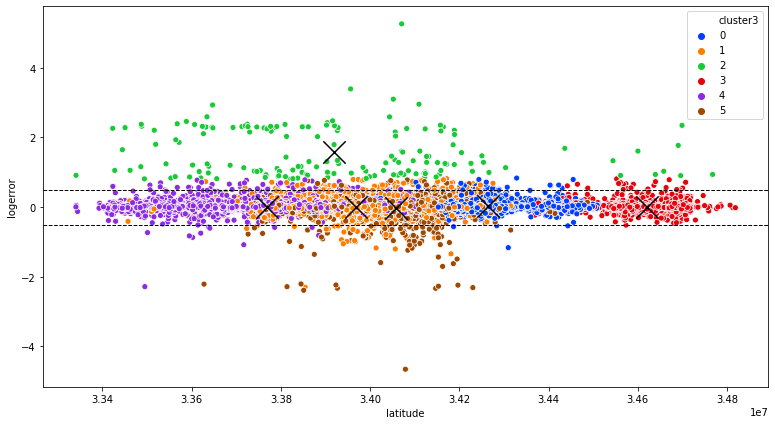

In [33]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='latitude', y='logerror', hue='cluster3', palette='bright')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster3').mean().plot.scatter(y='logerror', x='latitude', 
                                             marker='x', s=500, ax=ax, c='black')

In [34]:
train.cluster3.value_counts()

4    9384
1    7771
5    6023
0    5507
3    2183
2     160
Name: cluster3, dtype: int64

### Clustering Group 4: (logtaxvaluedollarcnt, logerror), (yearbuilt)

In [35]:
# Choose Group 4 to cluster on

cols_to_cluster = ['logtaxvaluedollarcnt', 'logerror', 'yearbuilt']
train_g4 = train[cols_to_cluster]
validate_g4 = validate[cols_to_cluster]
test_g4 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g4_scaled, validate_g4_scaled, test_g4_scaled = prepare.standard_scaler(train_g4, 
                                                                                      validate_g4, 
                                                                                      test_g4)
scaler, train_g4_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 3))

In [36]:
train_g4_scaled.head()

,logtaxvaluedollarcnt,logerror,yearbuilt
71142,0.263456,0.151133,-0.546518
11459,0.167803,-0.096466,1.497029
54330,0.115565,-0.172529,0.323077
46830,-1.506076,-0.270126,-0.416078
53521,-1.763605,-0.316977,-0.329119


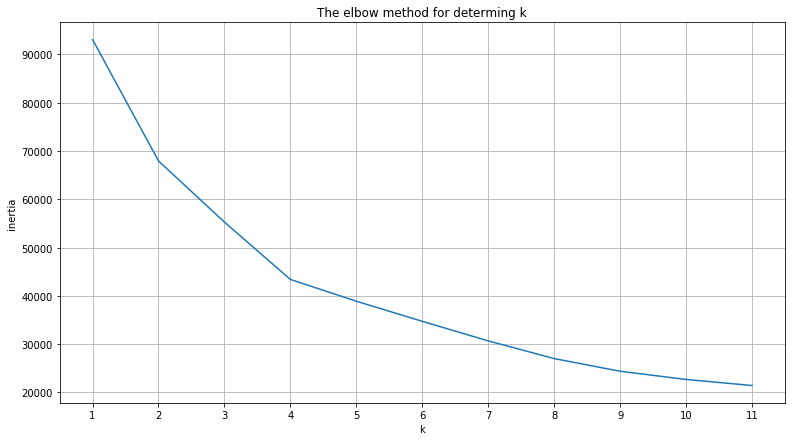

In [39]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g4_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [40]:
kmeans4, cluster4 = model.kmeans_labels(train_g4_scaled, cols_to_cluster, 6)
cluster4.head()

,cluster
71142,2
11459,0
54330,2
46830,4
53521,4


In [41]:
kmeans4.inertia_

34766.253323891164

In [42]:
train = pd.concat([train, cluster4], axis=1)
train.rename(columns={'cluster': 'cluster4'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2,cluster3,cluster4
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,5302.10,0.045179,1,0,1,5.640375,1,0,0,2
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,6231.12,0.000996,1,0,0,5.601164,1,0,0,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,4447.62,-0.012577,0,1,0,5.579750,1,0,4,2
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,1311.36,-0.029993,0,0,0,4.914993,0,0,1,4
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,1066.06,-0.038353,0,1,0,4.809425,0,0,1,4


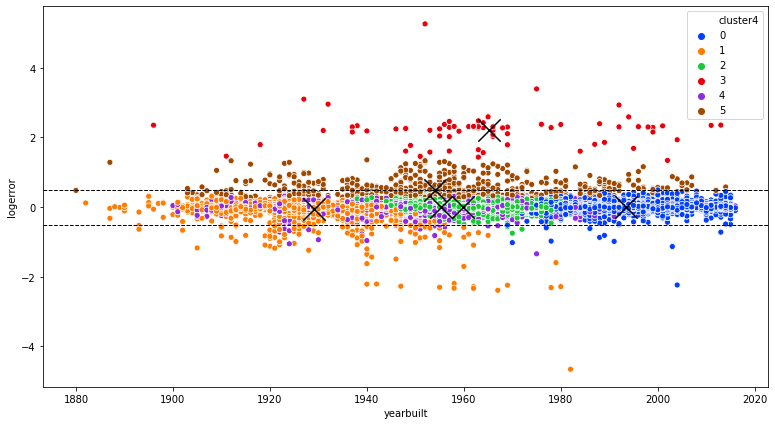

In [43]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='cluster4', palette='bright')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster4').mean().plot.scatter(y='logerror', x='yearbuilt', 
                                             marker='x', s=500, ax=ax, c='black')

In [44]:
train.cluster4.value_counts()

2    11644
0     7952
4     6809
1     3773
5      776
3       74
Name: cluster4, dtype: int64

In [56]:
# train.to_csv('train.csv', index=False)

### Predict validate and test dataset using kmeans1 and kmeans2

In [45]:
# Check sccaled validate dataset

validate_g1_scaled.head()

,logtaxvaluedollarcnt,logerror
16785,-2.061029,-1.633148
38299,-1.567902,0.248315
7485,-1.661734,0.040256
10725,0.629801,-0.189357
58497,0.032227,-0.082918


In [46]:
validate_g2_scaled.head()

,taxvaluedollarcnt,logerror
16785,-0.645671,-1.633148
38299,-0.606964,0.248315
7485,-0.615779,0.040256
10725,0.116922,-0.189357
58497,-0.239982,-0.082918


In [47]:
# Predict cluster1 and cluster2 in validate dataset

cluster1_v = pd.DataFrame(kmeans1.predict(validate_g1_scaled), columns=['cluster1'], 
                          index=validate_g1_scaled.index)
cluster2_v = pd.DataFrame(kmeans2.predict(validate_g2_scaled), columns=['cluster2'], 
                          index=validate_g2_scaled.index)

validate = pd.concat([validate, cluster1_v, cluster2_v], axis=1)
validate.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
16785,11427736,2.0,3.0,6.0,1124.0,1124.0,2.0,33924296.0,-118313958.0,5403.0,...,48697.0,25446.0,807.24,-0.273218,0,0,0,4.687502,0,0
38299,12517832,1.0,3.0,6.0,1245.0,1245.0,1.0,33801979.0,-118101279.0,5083.0,...,77562.0,37662.0,1079.82,0.062521,1,0,0,4.889649,0,0
7485,11007754,2.0,3.0,6.0,1219.0,1219.0,2.0,34322551.0,-118409326.0,7501.0,...,70988.0,16542.0,982.93,0.025393,1,0,0,4.851185,0,0
10725,11139580,3.0,4.0,8.0,3433.0,3433.0,3.0,34372039.0,-118548688.0,23475.0,...,617377.0,212632.0,8151.23,-0.015580,0,0,0,5.790550,5,0
58497,14231041,2.0,3.0,6.0,1503.0,1503.0,2.0,33803984.0,-117824682.0,6000.0,...,351227.0,258171.0,3975.60,0.003414,1,1,0,5.545588,1,0


In [53]:
# validate.to_csv('validate.csv', index=False)

In [51]:
# Predict cluster1 and cluster2 in test dataset

cluster1_t = pd.DataFrame(kmeans1.predict(test_g1_scaled), columns=['cluster1'], 
                          index=test_g1_scaled.index)
cluster2_t = pd.DataFrame(kmeans2.predict(test_g2_scaled), columns=['cluster2'], 
                          index=test_g2_scaled.index)

test = pd.concat([test, cluster1_t, cluster2_t], axis=1)
test.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
52775,13947663,2.5,3.0,6.0,1572.0,1572.0,2.0,33771569.0,-117976720.0,3575.0,...,317019.0,185049.0,3966.36,0.011628,1,1,0,5.501085,1,0
37893,12499543,2.0,4.0,4.0,1432.0,1432.0,2.0,33814652.0,-118201811.0,5388.0,...,388324.0,306414.0,4755.82,-0.041809,0,0,0,5.589194,1,0
37411,12478982,2.0,3.0,4.0,1479.0,1479.0,2.0,33862045.0,-118121519.0,5682.0,...,430258.0,289132.0,5171.65,0.363231,1,0,0,5.633729,4,2
13555,11237212,3.0,4.0,8.0,2529.0,2529.0,3.0,34549583.0,-118059891.0,7143.0,...,233877.0,46774.0,5047.39,0.056508,1,0,0,5.368988,1,0
58662,14239147,1.5,3.0,6.0,1343.0,1343.0,1.0,33783800.0,-117875000.0,932.0,...,187552.0,93055.0,2211.70,0.063789,1,1,0,5.273122,1,0


In [54]:
# test.to_csv('test.csv', index=False)

## Scale train/validate/test by standardscaler

In [57]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2,cluster3,cluster4
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,5302.10,0.045179,1,0,1,5.640375,1,0,0,2
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,6231.12,0.000996,1,0,0,5.601164,1,0,0,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,4447.62,-0.012577,0,1,0,5.579750,1,0,4,2
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,1311.36,-0.029993,0,0,0,4.914993,0,0,1,4
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,1066.06,-0.038353,0,1,0,4.809425,0,0,1,4


In [59]:
validate.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
16785,11427736,2.0,3.0,6.0,1124.0,1124.0,2.0,33924296.0,-118313958.0,5403.0,...,48697.0,25446.0,807.24,-0.273218,0,0,0,4.687502,0,0
38299,12517832,1.0,3.0,6.0,1245.0,1245.0,1.0,33801979.0,-118101279.0,5083.0,...,77562.0,37662.0,1079.82,0.062521,1,0,0,4.889649,0,0
7485,11007754,2.0,3.0,6.0,1219.0,1219.0,2.0,34322551.0,-118409326.0,7501.0,...,70988.0,16542.0,982.93,0.025393,1,0,0,4.851185,0,0
10725,11139580,3.0,4.0,8.0,3433.0,3433.0,3.0,34372039.0,-118548688.0,23475.0,...,617377.0,212632.0,8151.23,-0.015580,0,0,0,5.790550,5,0
58497,14231041,2.0,3.0,6.0,1503.0,1503.0,2.0,33803984.0,-117824682.0,6000.0,...,351227.0,258171.0,3975.60,0.003414,1,1,0,5.545588,1,0


In [60]:
test.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
52775,13947663,2.5,3.0,6.0,1572.0,1572.0,2.0,33771569.0,-117976720.0,3575.0,...,317019.0,185049.0,3966.36,0.011628,1,1,0,5.501085,1,0
37893,12499543,2.0,4.0,4.0,1432.0,1432.0,2.0,33814652.0,-118201811.0,5388.0,...,388324.0,306414.0,4755.82,-0.041809,0,0,0,5.589194,1,0
37411,12478982,2.0,3.0,4.0,1479.0,1479.0,2.0,33862045.0,-118121519.0,5682.0,...,430258.0,289132.0,5171.65,0.363231,1,0,0,5.633729,4,2
13555,11237212,3.0,4.0,8.0,2529.0,2529.0,3.0,34549583.0,-118059891.0,7143.0,...,233877.0,46774.0,5047.39,0.056508,1,0,0,5.368988,1,0
58662,14239147,1.5,3.0,6.0,1343.0,1343.0,1.0,33783800.0,-117875000.0,932.0,...,187552.0,93055.0,2211.70,0.063789,1,1,0,5.273122,1,0


In [62]:
# Create masks for group 1 in cluster1 and group 0 in cluster2. 

# mask for train dataset
mask_tr_cluster1_1 = (train.cluster1 == 1)
mask_tr_cluster2_0 = (train.cluster2 == 0)

# mask for validate dataset
mask_v_cluster1_1 = (validate.cluster1 == 1)
mask_v_cluster2_0 = (validate.cluster2 == 0)

# mask for test dataset
mask_t_cluster1_1 = (test.cluster1 == 1)
mask_t_cluster2_0 = (test.cluster2 == 0)

In [63]:
# Create train/validate/test for group 1 in cluster1

train_cluster1_1 = train[mask_tr_cluster1_1]
validate_cluster1_1 = validate[mask_v_cluster1_1]
test_cluster1_1 = test[mask_t_cluster1_1]

In [64]:
# Create train/validate/test for group 0 in cluster2

train_cluster2_0 = train[mask_tr_cluster2_0]
validate_cluster2_0 = validate[mask_v_cluster2_0]
test_cluster2_0 = test[mask_t_cluster2_0]

In [68]:
# Check the shape of the 2 train datasets

train_cluster1_1.shape, train_cluster2_0.shape

((15165, 25), (26841, 25))